In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 
import pandas as pd
from torch import nn
import collections

import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA


from data_loader import DataLoader
#import viewer functions
from dataViewer import plotTraj, animatePreview, animateLoc, animateTraj

import hdf5_utils as hd
from simulation import Agent, Engine
import h5py
import os


%matplotlib notebook
%load_ext autoreload
%autoreload 


np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def batch(arr1, arr2, n):
    """Yield successive n-sized chunks from l."""
    size = len(arr1)
    for i in range(0, size, n):
        yield arr1[i:min(i + n, size)], arr2[i:min(i + n, size)]
        
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
        

In [33]:


#hidden_layer = [32, 32, 64, 128, 128, 40]

#hidden_layer = [ 128, 128, 40, 32, 32, 64,]
#hidden_layer = [ 50, 30, 10, 20, 30, 30,]
#hidden_layer = [28 ,20, 10, 10]




load_traindata = True

dset = {'neighbors':7,
        'ret_vel':False,
        'nn_vel': False,
        'truth_with_vel': False,
        'shuffle':True,
        'mode': "wrap",
        'step_nr':1,
        'downsample':8,
        'fps':16,
        'name':  "ao-360-400_combine_f0"#"ug-100-045", #"ao-360-400_combine"
       }




param = {'input_s': 2+2*dset['ret_vel']  + dset['neighbors']*(2+2*dset['nn_vel']), #(number_nei+1)*4,
         'hidden_s': [50, 20, 50],
         'output_s': 2+dset['truth_with_vel']*2,
         'epochs':15,
         'batch_size':10,
         'lr':1e-3,
         'decay':0.1,
         'decay_step':5,
         #'dtype':torch.float,
         'device':torch.device("cpu"),
         'dataset':dset,
        }

#FPS = 16
#BG = "Datasets/UG/ug.png"

#PATH_1 = "Datasets/UG/UG-roh_nachkorrigiert/ug-100-007.txt"


PATH = "data/CSV/"
#PATH = "Datasets/UG/UG-roh_nachkorrigiert/"
PATH2 = "data/HD5/"


In [34]:

ds = DataLoader(PATH + dset['name'] + ".csv")

ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )


sufix = "_nn{}_s{}_vr{}_m{}_vi{}_st{}_d{}".format(dset['neighbors'],
                                 dset['shuffle'],
                                 dset['truth_with_vel'],
                                 dset['mode'],
                                 dset['ret_vel']+dset['nn_vel'], 
                                 dset['step_nr'],
                                 dset['downsample'])


f_name = PATH2+param['dataset']['name']+sufix+'.h5'

if os.path.isfile(f_name) and load_traindata:

    train, val, test, param['dataset'] = hd.load_trainingdata(f_name)
    print("Training data has been loaded")

else:
    #f_x = ds.flip_x

    augmentation = [] #[f_x]
    train, val, test = ds.get_train_data(dset['neighbors'], 
                                         step_nr=dset['step_nr'],
                                         downsample=dset['downsample'],
                                         augmentation=augmentation,
                                         ret_vel=dset['ret_vel'],
                                         nn_vel=dset['nn_vel'],
                                         shuffle=dset['shuffle'],
                                         truth_with_vel=dset['truth_with_vel'],
                                         mode=dset['mode'])
    dset['date'] = time.ctime()
    dset['creator'] = 'riesemichi'
    dset['augmentation'] = str(augmentation)
    param['dataset'] = dset
    
    hd.save_trainingdata(f_name, param, train, val, test)
    print("Training data saved to : {}".format(PATH2+f_name+sufix+'.h5'))

Persons:  350
Frame maximum : 821


100% (348 of 348) |######################| Elapsed Time: 0:02:13 Time:  0:02:13


loaded 346 trajectories
with augmentation 346 trajectories
346 (521, 16)
with downsample 2768 trajectories
extracted 91966 steps
Training data saved to : data/HD5/data/HD5/ao-360-400_combine_f0_nn7_sTrue_vrFalse_mwrap_vi0_st1_d8.h5_nn7_sTrue_vrFalse_mwrap_vi0_st1_d8.h5


In [35]:
hd.print_stats(PATH2+param['dataset']['name']+sufix+'.h5')

File: data/HD5/ao-360-400_combine_f0_nn7_sTrue_vrFalse_mwrap_vi0_st1_d8.h5/
|     Size: 6.35MB
|     @augmentation: []
|     @creator: riesemichi
|     @date: Tue Nov 24 21:23:54 2020
|     @downsample: 8
|     @fps: 16
|     @mode: wrap
|     @name: ao-360-400_combine_f0
|     @neighbors: 7
|     @nn_vel: False
|     @ret_vel: False
|     @shuffle: True
|     @step_nr: 1
|     @truth_with_vel: False
|
|Group: test 
|     |-----Dataset: input           - Shape: (18393, 16) float32
|     |-----Dataset: truth           - Shape: (18393, 2) float32
|
|Group: train 
|     |-----Dataset: input           - Shape: (55179, 16) float32
|     |-----Dataset: truth           - Shape: (55179, 2) float32
|
|Group: val 
|     |-----Dataset: input           - Shape: (18394, 16) float32
|     |-----Dataset: truth           - Shape: (18394, 2) float32


# Format training data as tensors

In [36]:
t_input, t_truth = train
v_input, v_truth = val
test_input, test_truth = test

t_i = torch.from_numpy(t_input).to(param['device'])
t_t = torch.from_numpy(t_truth).to(param['device'])

v_i = torch.from_numpy(v_input).to(param['device'])
v_t = torch.from_numpy(v_truth).to(param['device'])

test_i = torch.from_numpy(test_input).to(param['device'])
test_t = torch.from_numpy(test_truth).to(param['device'])




# Define Model

In [44]:


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc_in = nn.Linear(input_size, hidden_size[0]) 
        
        #self.fc_hidden = []
        #for i in range(len(hidden_size)-1):
        self.fc_hidden_1 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc_hidden_2 = nn.Linear(hidden_size[1], hidden_size[2])
        #self.fc_hidden_3 = nn.Linear(hidden_size[2], hidden_size[3])
        
        #self.fc_hidden_4 = nn.Linear(hidden_size[3], hidden_size[4])
        #self.fc_hidden_5 = nn.Linear(hidden_size[4], hidden_size[5])

        
        self.fc_out = nn.Linear(hidden_size[-1], output_size)
        self.relu = nn.ReLU()
        #self.drop = nn.Dropout(0.1)
    
    def forward(self, x):
     
        out = self.relu(self.fc_in(x))
        
        #for i in range(len(self.fc_hidden)):
        #    out = self.relu(self.fc_hidden[i](out))
        
        out = self.relu(self.fc_hidden_1(out))
        out = self.relu(self.fc_hidden_2(out))
        #out = self.relu(self.fc_hidden_3(out))
        #out = self.relu(self.fc_hidden_4(out))
        #out = self.drop(out)
        #out = self.relu(self.fc_hidden_5(out))
        
        
        out = self.fc_out(out)
        return out


model = NeuralNet(param['input_s'], param['hidden_s'], param['output_s']).to(param['device'])


In [45]:
#choose loss function - can be played around with
loss_fn = torch.nn.MSELoss(reduction='mean')


optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=param['decay_step'], gamma=param['decay'])


In [46]:

d_len = t_i.shape[0]


#pbar = progressbar.ProgressBar(max_value=param['epochs'])
#widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = progressbar.ProgressBar(widgets=widgets, maxval=param['epochs']*d_len)
pbar.start()

training_loss = []
validation_loss = [0.0]

for t in range(param['epochs']):
    
    # Train on Batches
    
    p = np.random.permutation(len(t_i))
    t_i = t_i[p]
    t_t = t_t[p]
    
    for  y, (t_i_b, t_t_b) in  enumerate(batch(t_i, t_t, param['batch_size'])):
        y_pred = model(t_i_b)
       
        loss = loss_fn(y_pred, t_t_b)

        optimizer.zero_grad()
       
        loss.backward()

        optimizer.step()
        
        widgets[0] = FormatLabel('loss(t/v) : {:.4} / {:.4} | lr={:.4}'.format(loss.item(),
                                                                            validation_loss[-1],
                                                                            optimizer.param_groups[0]['lr']))
        pbar.update(t*d_len+y*param['batch_size'])
        
        if y%10==9:
            training_loss += [loss.cpu().detach().numpy()]
    
    # Test on validation
    
    loss = []
    with torch.no_grad():
        for v_i_b, v_t_b in batch(v_i, v_t, param['batch_size']):
            y_pred = model(v_i_b)
            loss += [loss_fn(y_pred, v_t_b).cpu().detach().numpy()]
            pbar.update()
    validation_loss.append( np.array(loss).mean() )
    
    scheduler.step()
        

pbar.finish()




100% (15 of 15) |########################| Elapsed Time: 0:00:00 ETA:  00:00:00
 100% |########################################################| Time:  0:02:00


<IPython.core.display.Javascript object>


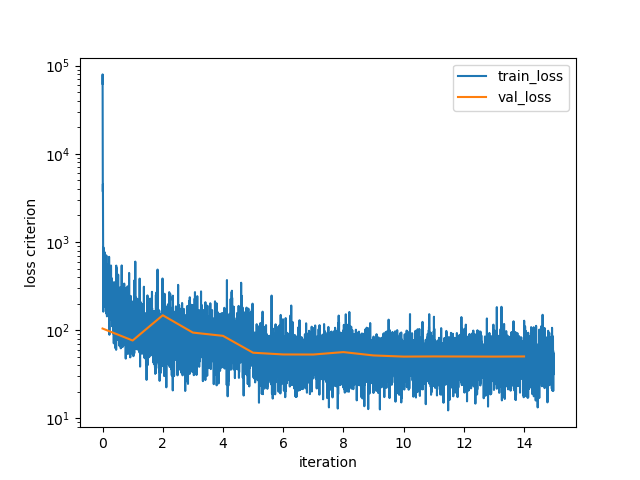

15
8265


In [47]:

train_loss = np.array(training_loss)
val_loss = np.array(validation_loss[1:])

plt.figure()
plt.semilogy(np.arange(len(train_loss))*10*param['batch_size']/d_len, train_loss, label="train_loss")
plt.semilogy(np.arange(len(val_loss)), val_loss, label="val_loss" )
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.legend()
plt.show()
print(len(val_loss))
print(len(train_loss))

In [205]:
model.eval()



NeuralNet(
  (fc_in): Linear(in_features=28, out_features=32, bias=True)
  (fc_hidden_1): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_2): Linear(in_features=32, out_features=64, bias=True)
  (fc_hidden_3): Linear(in_features=64, out_features=128, bias=True)
  (fc_hidden_4): Linear(in_features=128, out_features=128, bias=True)
  (fc_hidden_5): Linear(in_features=128, out_features=40, bias=True)
  (fc_out): Linear(in_features=40, out_features=4, bias=True)
  (relu): ReLU()
)

# Check on test set

100% (18393 of 18393) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


<IPython.core.display.Javascript object>


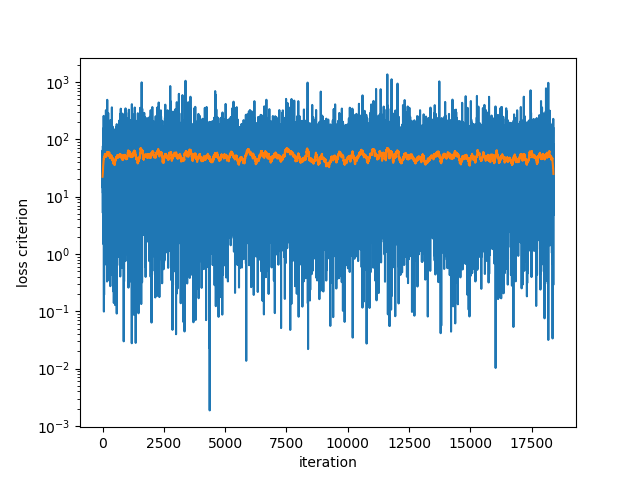

In [48]:

test_dat = []

pbar = progressbar.ProgressBar(maxval=len(test_i))
pbar.start()

i = 0

with torch.no_grad():
    for (ti, tt) in zip(test_i, test_t):
        pred = model(ti)
        loss = loss_fn(pred, tt)
        test_dat.append(loss.cpu().detach().numpy())
     
        if i%10:
            pbar.update(i)
        
        i += 1
        
    pbar.finish()
    
test_dat = np.array(test_dat)

plt.figure()
plt.semilogy(np.arange(len(test_dat)), test_dat)
plt.semilogy(np.arange(len(test_dat)), smooth(test_dat, 100))
plt.xlabel("iteration")
plt.ylabel("loss criterion")
plt.show()

# Save/ Load model

In [49]:
PATH_M = "data/model/"
#name = "model_UG_downsample_good_"
#name = "model_UG_downsample_good_"
name = "mneck"

suffix_m = "_nn{}_vel{}{}_{}_s{}_{}_{}_e{}_lr{}".format(param['dataset']['neighbors'],
                                                         param['dataset']['ret_vel'],param['dataset']['nn_vel'],param['dataset']['truth_with_vel'],
                                                         param['input_s'],param['hidden_s'],param['output_s'],
                                                         param['epochs'],
                                                         param['lr'],
                                                        )


#f_name = PATH_M+name+"sweep_vel.h5"
f_name = PATH_M+name+suffix_m+".h5"    

#hd.print_stats(f_name)
suffix_m

'_nn7_velFalseFalse_False_s16_[50, 20, 50]_2_e15_lr0.001'

In [51]:

param['msg'] = "network for bottleneck - michaelneck "


hd.save_torch(model, optimizer, f_name, param, prefix="", scan=False) # prefix for scans

HDF5Error: Cannot write to file that already exists: data/model/mneck_nn7_velFalseFalse_False_s16_[50, 20, 50]_2_e15_lr0.001.h5

In [29]:
model , param = hd.load_torch(f_name, NeuralNet, prefix="")
model.eval()

multi_model
{'hidden_s': array([ 32,  32,  64, 128, 128,  40]), 'input_s': 28, 'layers': array(['fc_in.weight', 'fc_in.bias', 'fc_hidden_1.weight',
       'fc_hidden_1.bias', 'fc_hidden_2.weight', 'fc_hidden_2.bias',
       'fc_hidden_3.weight', 'fc_hidden_3.bias', 'fc_hidden_4.weight',
       'fc_hidden_4.bias', 'fc_hidden_5.weight', 'fc_hidden_5.bias',
       'fc_out.weight', 'fc_out.bias'], dtype=object), 'output_s': 4}


/home/zehndi/CNN/Projects/ai-team/hdf5_utils.py:180: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  stat[l] = torch.from_numpy(mod.get(l).value,).to(layer_param['device'])


NeuralNet(
  (fc_in): Linear(in_features=28, out_features=32, bias=True)
  (fc_hidden_1): Linear(in_features=32, out_features=32, bias=True)
  (fc_hidden_2): Linear(in_features=32, out_features=64, bias=True)
  (fc_hidden_3): Linear(in_features=64, out_features=128, bias=True)
  (fc_hidden_4): Linear(in_features=128, out_features=128, bias=True)
  (fc_hidden_5): Linear(in_features=128, out_features=40, bias=True)
  (fc_out): Linear(in_features=40, out_features=4, bias=True)
  (relu): ReLU()
)

In [52]:
hd.print_stats(f_name)

File: data/model/mneck_nn7_velFalseFalse_False_s16_[50, 20, 50]_2_e15_lr0.001.h5/
|     Size: 44.14KB
|     @batch_size: 10
|     @creator: zehndiii
|     @date: Tue Nov 24 21:54:25 2020
|     @decay: 0.1
|     @decay_step: 5
|     @device: cpu
|     @epochs: 15
|     @lr: 0.001
|     @mode: single_model
|     @msg: First network for bottleneck - michaelneck 
|
|Group: dataset 
|     @augmentation: []
|     @creator: riesemichi
|     @date: Tue Nov 24 21:23:54 2020
|     @downsample: 8
|     @fps: 16
|     @mode: wrap
|     @name: ao-360-400_combine_f0
|     @neighbors: 7
|     @nn_vel: False
|     @ret_vel: False
|     @shuffle: True
|     @step_nr: 1
|     @truth_with_vel: False
|
|Group: model 
|     @hidden_s: [50 20 50]
|     @input_s: 16
|     @layers: ['fc_in.weight' 'fc_in.bias' 'fc_hidden_1.weight' 'fc_hidden_1.bias'
 'fc_hidden_2.weight' 'fc_hidden_2.bias' 'fc_out.weight' 'fc_out.bias']
|     @output_s: 2
|     |-----Dataset: fc_hidden_1.bias - Shape: (20,) float32
|     |   

['hallo']

# Single agent

In [53]:



test_person = 22

da = DataLoader(None)


da.copy(ds)
# crop the standing phase
#da.data = da.data[ da.data['f']>100]

frames_o, pos_vel_o = da.person(test_person, )
#frames, pos_vel = da.grab_roi(frames_o, pos_vel_o, x_pad=50)

da.remove_person(test_person)

print(frames_o[0], frames_o[-1])

agent = Agent(model,
              FPS=param['dataset']['fps']/param['dataset']['downsample'],
              pos_vel_0=pos_vel_o[0],
              frame_0=frames_o[0],
              truth_with_vel=param['dataset']['truth_with_vel'],
              device=param['device'],
              id=1000+test_person )



print(agent.id )
print(pos_vel_o[0])


sim = Engine(da, agents=[agent],
             stop_agent=True,
             nn=param['dataset']['neighbors'],
             ret_vel=param['dataset']['ret_vel'],
             nn_vel=param['dataset']['nn_vel'],
             truth_with_vel=param['dataset']['truth_with_vel'],
             mode=param['dataset']['mode'],
             downsample=param['dataset']['downsample'],
            )

sim.run(0, 1000)#frames_o[-1], )


dp = DataLoader(None)
dp.copy(sim.ds)
dp.append_person(test_person, frames_o, pos_vel_o[:,:2], vel=pos_vel_o[:,2:] )


100 331
1022
[-408.983   -30.4024   48.544    12.1184]
sim from : 0 to 1000


 100% |########################################################| Time:  0:00:02


In [116]:
def get_mean_speed(data, id, use_roi=True, mode="both", normalize=False, pos=(0, 0)):
    
    frames, pos_vel = data.person(id)
    frames, pos_vel = data.grab_roi(frames, pos_vel, x_pad=-50)
    
    if not normalize:
        if mode =='x':
             vel_m = pos_vel[:,2].mean()
        elif mode == 'y':
             vel_m = pos_vel[:,3].mean()
        elif mode == 'both':
             vel_m = np.sqrt((pos_vel[:,2:]**2).sum(axis=1)).mean()
    else:
        if mode =='x':
            vel = pos_vel[:,2]
            
            r = pos_vel[0] - pos[0]
            vel /= r
            
            vel_m = vel.mean()
        elif mode == 'y':
            vel = pos_vel[:,3]
            
            r = pos_vel[1] - pos[1]
            vel /= r
            
            vel_m = vel.mean()
        elif mode == 'both':
            vel = np.sqrt((pos_vel[:,2:]**2).sum(axis=1))
            
            r = np.sqrt(( (pos_vel[:,:2]-pos)**2).sum(axis=1))
            vel /= r
            
            vel_m = vel.mean()
        
    
    
    #print(frames)
    #print(pos_vel)
    print("ID ", id ," vel :",  vel_m)

get_mean_speed(dp, test_person, normalize=True)
get_mean_speed(dp, 1000+test_person, normalize=True)
    

ID  10  vel : 1.3024526010134208
ID  1010  vel : 1.02589322038623


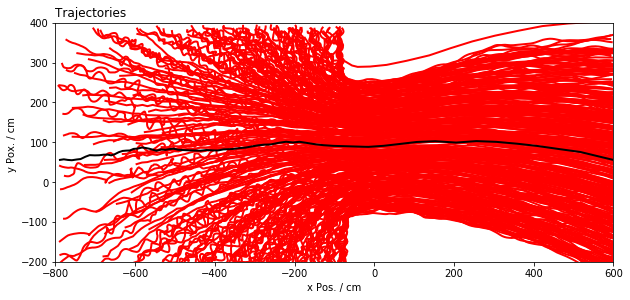

In [82]:
plotTraj(dp,  boundaries=[-800, 600, -200, 400],
         people=None,
         ai=[ 1000+test_person],#test_person,
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

<IPython.core.display.Javascript object>


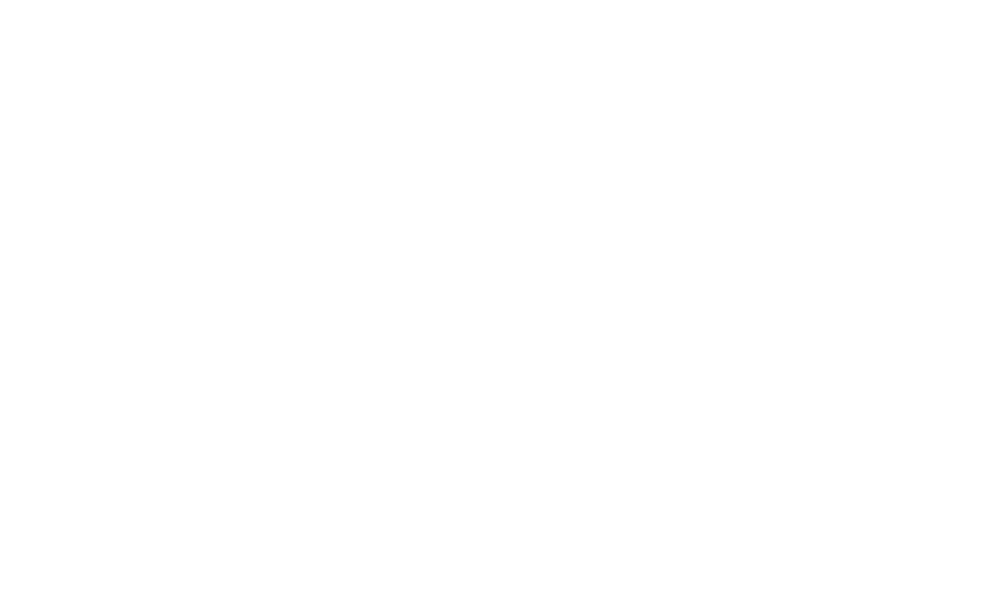

In [56]:
ani = animateLoc(dp, frame_start=frames_o[0], frame_stop=800,ai=[1000+test_person],
             boundaries=[-800, 600, -200, 400], step=param['dataset']['downsample'], fps=16, title="ululululu", save=False,
             path="downsapling_8.gif"
             )
display(ani)

In [ ]:
animatePreview(dp, boundaries=[-600, 600, -250, 150], step=5)

In [ ]:
ani = animateTraj(dp, frame_start=frames_o[0], frame_stop=frames_o[-1], boundaries=[-600, 600, -250, 150], step=1, fps=16, title="Trajectory Animation")
ani

In [83]:
type(param['input_s'])
mask = 0
mask = np.zeros(5)

# Multi agent simulation

People in Dataset:  169
Agents in Dataset:  179
Frame max:  666
sim from : 100 to 666


 100% |########################################################| Time:  0:00:27


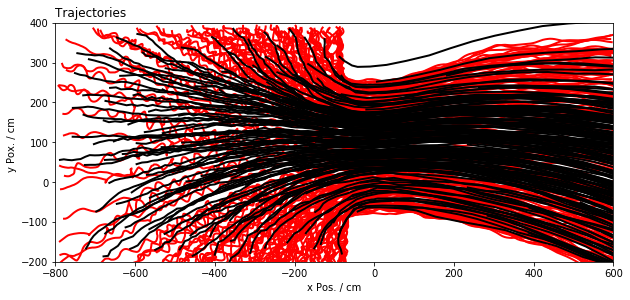

In [134]:
agents_id = np.array([10, 13, 16,  20, 22, 26,  30, 35, 40, ]) #120, 160, 200])

agents_id, _ = ds.frame(100)
#agents_id, _ = ds.frame(5)


da = DataLoader(None)

da.copy(ds)
#da.data = da.data[ da.data['f']>200


#agents_id = da.data['p'].unique()[::5]

agents = []

frame_max = 0

for test_person in agents_id:

    frames_o, pos_vel_o =  da.person( test_person, )
    #frames_o, pos_vel_o =  da.grab_roi( *da.person(test_person, ), x_pad=100 )
    
    #get_mean_speed(da, test_person)
    da.remove_person(test_person)

    
    if len(frames_o)<1:
        continue
    
    frame_max = max(frames_o[-1], frame_max)
    
    agents += [Agent(model,
                     FPS=param['dataset']['fps']/param['dataset']['downsample'],
                     pos_vel_0=pos_vel_o[0],
                     frame_0=frames_o[0],
                     truth_with_vel=param['dataset']['truth_with_vel'],
                     device=param['device'],
                     id=1000+test_person )]

#for id in da.data['p'].unique():
#    da.remove_person(id)

print("People in Dataset: ", da.persons)
print("Agents in Dataset: ", len(agents))
print("Frame max: ", frame_max)

sim = Engine(da, agents=agents,
             nn=param['dataset']['neighbors'],
             ret_vel=param['dataset']['ret_vel'],
             nn_vel=param['dataset']['nn_vel'],
             truth_with_vel=param['dataset']['truth_with_vel'],
             mode=param['dataset']['mode'],
             downsample=param['dataset']['downsample'],
             stop_agent=True)

sim.run(100,frame_max, )



dp = DataLoader(None)
dp.copy(sim.ds)


plotTraj(dp,  boundaries=[-800, 600, -200, 400],
         people=None,
         ai=agents_id+1000,
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

In [167]:
#for j in agents_id:
#    get_mean_speed(dp, 1000+j)


dl = DataLoader(None)

dl.copy(dp)

agents_id, _ = ds.frame(100)

pbar = progressbar.ProgressBar(maxval=len(agents_id))
pbar.start()

#for (i,agent) in enumerate(agents_id+1000):
dl.interpolate_person(1150)
pbar.update(1)
    
pbar.finish()
    


100% (179 of 179) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


In [168]:
ani = animateLoc(dl, frame_start=100, frame_stop=400,ai=150+1000,
             boundaries=[-800, 600, -200, 400], step=1, fps=16, title="ululululu", save=False,
             path="downsapling_8_multi.gif")
display(ani)

In [84]:
PATH_S = "data/sim/"
#name = "model_UG_downsample_good_"
#name = "model_UG_downsample_good_"
name = "mneck"


#f_name = PATH_M+name+"sweep_vel.h5"
f_name = PATH_S+name+suffix_m

dp.save(f_name)

In [151]:
frames = temp['f'].to_numpy()
fmin, fmax = int(frames.min()), int(frames.max())

In [152]:
for f in range(fmin, fmax):
    if not f in frames.astype(int):
        dl.data = dl.data.append(pd.DataFrame([np.array([id, f, np.nan,  np.nan,  0,  np.nan,  np.nan])], columns=list(dl.data)), ignore_index=True)
dl.data = dl.data.sort_values(["p", "f"], ascending = (True, True))
dl.data = dl.data.interpolate()


In [153]:
dl.data[(dl.data['p'] == id) & (dl.data['f'] < 109)]

,p,f,y,x,z,vx,vy
55408,1150.0,100.0,-169.954000,-549.722000,0.0,5.184000,43.536000
61306,1150.0,101.0,-169.425830,-548.684301,0.0,6.611397,39.150341
61307,1150.0,102.0,-168.897659,-547.646603,0.0,8.038795,34.764681
61308,1150.0,103.0,-168.369489,-546.608904,0.0,9.466192,30.379022
61309,1150.0,104.0,-167.841319,-545.571205,0.0,10.893590,25.993362
61310,1150.0,105.0,-167.313149,-544.533506,0.0,12.320987,21.607703
61311,1150.0,106.0,-166.784978,-543.495808,0.0,13.748385,17.222043
61312,1150.0,107.0,-166.256808,-542.458109,0.0,15.175782,12.836384
55587,1150.0,108.0,-165.728638,-541.420410,0.0,16.603180,8.450725


In [ ]:
def load_torch(f_name, MODEL_class):
    
    db = h5py.File(f_name, 'r')
    
    params = hd.load_attrs(db)
    db_params = hd.load_attrs(db['dataset'])
    
    mod = db['model']
    mod_params = hd.load_attrs(mod)
    
    params['dataset'] = db_params
    params['input_s'] = mod_params['input_s'],
    params['hidden_s'] = mod_params['hidden_s'],
    params['output_s'] = mod_params['output_s'],
    params['device'] = torch.device(params['device'])
    
    
    model = MODEL_class(mod_params['input_s'], mod_params['hidden_s'], mod_params['output_s'])
    
    
    stat = collections.OrderedDict() 
    for l in mod_params['layers']:
        layer_param = hd.load_attrs(mod[l])
        stat[l] = torch.from_numpy(mod.get(l).value,).to(layer_param['device'])
    
    db.close()
    
    model.load_state_dict(stat)
    
    
    
    return model, params


def save_torch(model, optimizer, f_name, param, crator="zehndiii"):
    #TODO Apend mode
    #TODO no overwrite
    
    db = h5py.File(f_name, 'w')
    
    # write general settings
    hd.write_attrs(db, {'creator':"zehndiii",       # write general attributes
                      'date':time.ctime(),
                      'epochs':param['epochs'],
                      'batch_size':param['batch_size'],
                #'optimizer':str(type(optimizer)),
                      'lr':param['lr'],
                      'decay':param['decay'],
                      'decay_step':param['decay_step'],
                      'device':str(param['device'])
                       })
    
    

    # write dataset settings
    dataset = db.create_group('/dataset')
    
    hd.write_attrs(dataset, param['dataset'])
    """
    {'creator':creator,       # write general attributes
                      'date':date,
                      'neighbors':number_nei,
                      'augmentation':str(augmentation),
                      'shuffle':shuffle,
                      'truth_with_vel':truth_with_vel,
                      'mode':mode,
                      'fps':FPS
                     }
    """
    
    # write model and settings
    mod = db.create_group('/model')
   
    stat = model.state_dict()
    
    layers = []
    
    for k, v in stat.items():
        
        layers += [k]
        
        dat = v.cpu().detach().numpy()
        ds = mod.create_dataset( name=k,shape=v.shape, 
                                         dtype=dat.dtype,
                                         data=dat, compression="lzf" )

        hd.write_attrs(ds, {'device':str(v.device.type),
                            'dtype':str(v.dtype),
                         })
    
    hd.write_attrs(mod, {'input_s':param['input_s'],
                         'hidden_s':param['hidden_s'],
                         'output_s':param['output_s'],
                         'layers':layers,
                         })
    
    db.close()

In [7]:
# hdf 5 dump

f_name = PATH2+param['dataset']['name']+sufix+'.h5'

def save_trainingdata(f_name, train, val, test ):


    database = h5py.File(f_name, 'w')

    hd.write_attrs(database, param['dataset'] ) 
    
    train_h = database.create_group('/train')
    train_h.create_dataset( name='input',shape=train[0].shape, 
                                         dtype=train[0].dtype,
                                         data=train[0], compression="lzf" )
    train_h.create_dataset( name='truth',shape=train[1].shape, 
                                         dtype=train[1].dtype,
                                         data=train[1], compression="lzf" )
    val_h = database.create_group('/val')
    val_h.create_dataset( name='input',shape=val[0].shape, 
                                         dtype=val[0].dtype,
                                         data=val[0], compression="lzf" )
    val_h.create_dataset( name='truth',shape=val[1].shape, 
                                         dtype=val[1].dtype,
                                         data=val[1], compression="lzf" )
    test_h = database.create_group('/test')
    test_h.create_dataset( name='input',shape=test[0].shape, 
                                         dtype=test[0].dtype,
                                         data=test[0], compression="lzf" )
    test_h.create_dataset( name='truth',shape=test[1].shape, 
                                         dtype=test[1].dtype,
                                         data=test[1], compression="lzf" )

    database.close()
    print("Training data saved to : {}".format(PATH2+fname+sufix+'.h5'))
    
def load_trainingdata(file_name):
    database = h5py.File(file_name, 'r')                  # open db

    param['dataset'] = hd.load_attrs(database)                        # print attrs if debug

    train = (database.get('train/input').value, database.get('train/truth').value )
    val = (database.get('val/input').value, database.get('val/truth').value )
    test = (database.get('test/input').value, database.get('test/truth').value )

    database.close()
    return train, val, test

In [ ]:
torch.save(model.state_dict(), "data/model/model_paper_dropout.dat")
load_path = "data/model/model_paper_dropout.dat"

model = NeuralNet(D_in, hidden_layer, D_out).to(device)

model.load_state_dict(torch.load(load_path))
model.eval()



In [ ]:
ai = sim.agents[0]
tr = np.vstack( ai.traj )

print("agent")
print(tr[:5])

print(ai.pos)
frames, traj = sim.ds.person(test_person+1000)

print("dataset")
#print(frames[:])
print(traj[:5])

plt.figure()

offset = 0
end = -1
plt.plot(tr[:,0], tr[:,1]) 



plt.plot(traj[offset: end,0], traj[offset:end,1])

print(frames[offset])

#plt.xlim([-600, 600])
#plt.ylim([-150, 150])

plt.show()

"""
[[-342.531 -3.04867 -1.024000000000342 4.645119999999999]
 [-332.4825439453125 -3.1519365310668945 0.6280288696289062
  -0.006454154849052429]
 [-322.0271301269531 -2.130854606628418 0.6534633636474609
  0.06381762027740479]
 [-312.77081298828125 -3.785721778869629 0.5785198211669922
  -0.10342919826507568]
 [-302.70819091796875 -2.7985124588012695 0.6289138793945312
  0.06170058250427246]]

"""

In [ ]:

#define network



model = torch.nn.Sequential(
    
    torch.nn.Linear(D_in, 50), 
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
    
    torch.nn.ReLU(),
    torch.nn.Linear(10, 50),
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.1),
    
    torch.nn.Linear(50, 30),
    
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.1),
    
    torch.nn.Linear(30, D_out), 
)



hidden_size = 28#50
hidden_size2 = 20
hidden_size3 = 10#50
hidden_size4 = 10


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size2) 
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
         
        out = self.drop( self.fc3(out) )
        
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

model = NeuralNet(D_in, hidden_size, hidden_size2, hidden_size3, hidden_size4,D_out).to(device)


#if device.type.startswith("cuda"):
#    model.cuda()

In [ ]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.model = torch.nn.ModuleDict({
            'lstm': torch.nn.LSTM(
                input_size=D_in,    # 45, see the data definition
                hidden_size=l_o,  # Can vary
            ),
            'linear1': torch.nn.Linear(
                in_features=l_o,
                out_features=D_out)
        })
        
    def forward(self, x):

        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        x = x.view(x_seq_len, -1, x_features)
       
        # Data is fed to the LSTM
        out, _ = self.model['lstm'](x)
        

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.view(x_batches, x_seqs, x_seq_len, -1)
      

        # Data is fed to the Linear layer
        out = self.model['linear1'](out)
       

        # The prediction utilizing the whole sequence is the last one
        y_pred = out[:, :, -1].unsqueeze(-1)
       

        return y_pred


model = Model()